---
title : "Report"
subtitle: "Applied Statistics course HdM 2023"
execute:
  echo: true # show code
format: 
  html: # output format
    embed-resources: true # create a self-contained html
    theme: 
      - custom.scss # additional custom scss
    toc: true # table of content
    number-depth: 3 # deepest level 
    toc-title: Contents # content title
    toc-location: left # toc alignment
    number-sections: true # use numbering
    html-math-method: mathjax # displays mathematical notation 
    smooth-scroll: true # smooth scrolling
editor:
  render-on-save: false
jupyter: python3 # use python
---

# Next steps

- compare different model results and explain which is the most suitable one
- compare error values between the models and show them in a table
- visualize Fits from the different models 
- optimize visualizations (title, axis label,..)
- hide lines of code for the final report

- Abschließende Korrekturlesung und Kürzung von Inhalten

## Setup

In [1]:
import pandas as pd
import numpy as np
import missingno as mno # needed to visualize missing values. install missingno into conda if import does not work!
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # needed for US map
import xlrd # needed to read excel files. install xlrd into conda if import does not work!
import shutil # needed to copy files
import time
import datetime
import warnings
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

warnings.simplefilter(action='ignore', category=FutureWarning)
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# Introduction and data

The aim of this project is to investigate, whether there is a correlation between the household income and the death rate in the United States of America. In order to explore this relation, we gathered data on both topics and will analyse how and to what extense the death rate is impacted by the household income.

### Research Question

We want to answer the following question:

**Does the household income have an impact on the deathrates in the U.S. and if yes, how big is it?**

Our hypotheses regarding the research question is:

**The household income and the death rate will have a negative correlation.**

Meaning, that the higher the household income is, the lower the death rate will be.

The predictor variable will be the median household income. The main response variable will be the age-adjusted death rate. Further insights can be gained by using categories like death cause, state or year. Other useful information will be provided by the amount of total deaths.
The data dictionary below, is showing more details about the required variables.

You can check the appendix for [additional information regarding the research question](#research_question).

<a id='data_dictionary'></a>

In [2]:
data = {
        'Name': [
                'state',
                'year',
                'median_household_income',
                'cause name',
                '113 cause name',
                'deaths',
                'Age-adjusted Death Rate'
                ], 
        'Description': [
                'the U.S. state where data was collected',
                'considered years (1999 - 2017)','median household income',
                'the generic name for the death cause',
                'NDI ICD-10 113 categories for causes of death',
                'count of the total deaths',
                'standardized ratio of deaths per 100k population'
                ],
        'Role': [
                'predictor',
                'predictor',
                'predictor',
                'predictor',
                'Not used',
                'response',
                'response'
                ],
        'Type': [
                'nominal',
                'numeric discrete',
                'numeric continuous',
                'nominal',
                'nominal',
                'numeric discrete',
                'numeric continuous'
                ],
        'Format': [
                'category',
                'date',
                'float',
                'category',
                'category',
                'int',
                'float'
                ],
        }
df = pd.DataFrame(data)
df

,Name,Description,Role,Type,Format
0,state,the U.S. state where data was collected,predictor,nominal,category
1,year,considered years (1999 - 2017),predictor,numeric discrete,date
2,median_household_income,median household income,predictor,numeric continuous,float
3,cause name,the generic name for the death cause,predictor,nominal,category
4,113 cause name,NDI ICD-10 113 categories for causes of death,Not used,nominal,category
5,deaths,count of the total deaths,response,numeric discrete,int
6,Age-adjusted Death Rate,standardized ratio of deaths per 100k population,response,numeric continuous,float


## Data

### Import data

In [3]:
# Declare variables
external_data = '..\\data\\external\\'
raw_data = '..\\data\\raw\\'
interim_data = '..\\data\\interim\\'
processed_data = '..\\data\\processed\\'
# File names
orig_income_file = 'Median_Household_Income_By_State_1990-2017.xls'
target_income_file = 'Median_Household_Income_By_State_1990-2017.csv'
orig_death_file = 'NCHS_-_Leading_Causes_of_Death__United_States.csv'
# Save external median income data as csv in folder 'raw'
# Read file
xls_household_file = pd.read_excel(external_data+orig_income_file)
# Save file
xls_household_file.to_csv(raw_data+target_income_file,index = None, header=True)
# Copy external leading cause of death data into folder 'raw'
shutil.copy(external_data+orig_death_file, raw_data+orig_death_file)
# Declare both dataframes
df_income = pd.read_csv(raw_data+target_income_file)
df_death = pd.read_csv(raw_data+orig_death_file)

### Data structure

In [4]:
df_death.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     10868 non-null  int64  
 1   113 Cause Name           10868 non-null  object 
 2   Cause Name               10868 non-null  object 
 3   State                    10868 non-null  object 
 4   Deaths                   10868 non-null  int64  
 5   Age-adjusted Death Rate  10868 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 509.6+ KB


In [5]:
df_death.head()

,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,United States,169936,49.4
1,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alabama,2703,53.8
2,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alaska,436,63.7
3,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arizona,4184,56.2
4,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arkansas,1625,51.8


In the death dataset we have 10868 cases and 6 columns.

In [6]:
df_income.head()

,"Table 102.30. Median household income, by state: Selected years, 1990 through 2017",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31
0,[In constant 2017 dollars. Standard errors app...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,State,1990\1\,2000\2\,2005.0,NaN,2010.0,NaN,2013.0,NaN,2014.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,3,4.0,NaN,5.0,NaN,6.0,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
3,United States ...........,57500,62000,58200.0,80.0,56400.0,40.0,55100.0,40.0,55600.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama ....................,45200,50400,46400.0,400.0,45600.0,320.0,45200.0,410.0,44400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data corrections

#### Income Dataset

From the overview, we have seen that the df_income dataset needs to be cleaned:

- define column names
- remove columns and rows with only null values
- remove unnecessary characters such as whitespaces or trailing dots
- transform the whole dataset by melting the data to only retain 3 columns
- rename the new columns to be lowercase
- declare correct column types

In [7]:
# We only need the first 16 columns 
# and we can also drop the columns 4,6,8,10,12 and 14 since they only show NaN values
column_lst = [0,1,2,3,5,7,9,11,13,15]
df_income_corrected = df_income[df_income.columns[column_lst]]
# We don't need row 0,2 and row 64-67
row_drop_lst = [0,2,64,65,66,67]
df_income_corrected = df_income_corrected.drop(row_drop_lst)
# There are a few rows with empty entries left, which we can get rid off 
# since those rows have no state assigned to it, they are only used as separators
df_income_corrected.dropna(inplace=True)
# The column names are actually in the first row, additionally they need to be adjusted
column_names = ['State','1990','2000','2005','2010','2013','2014','2015','2016','2017']
df_income_corrected.columns = column_names
# Row number 1 can be dropped
df_income_corrected.drop(1,inplace=True)
# The dots in the state column can be removed
# We also do not want any leading or ending spaces in the strings
df_income_corrected = df_income_corrected.replace(r'\.','',regex=True)
df_income_corrected['State'] = df_income_corrected['State'].str.strip()
# Lastly we reset the row index drop the old index 
df_income_corrected.reset_index(drop = True, inplace = True)
# We transform the table to show the median income for a state in a single year
# We use the melt() function for this
lst_years = column_names[1:]
df_income_corrected = df_income_corrected.melt(
    id_vars= ['State'], 
    value_vars= lst_years, 
    var_name= 'year', 
    value_name= 'median_household_income' 
    )
# The State column should be lowercase
df_income_corrected = df_income_corrected.rename(
    columns = {'State':'state'}
)
# The types need to be declared, state holds categorial values, year has integers and income holds float numbers
df_income_corrected['state'] = df_income_corrected['state'].astype('category')
df_income_corrected['year'] = df_income_corrected['year'].astype('int')
df_income_corrected['median_household_income'] = df_income_corrected['median_household_income'].astype('float')


In [8]:
df_income_corrected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   state                    468 non-null    category
 1   year                     468 non-null    int32   
 2   median_household_income  468 non-null    float64 
dtypes: category(1), float64(1), int32(1)
memory usage: 8.5 KB


In [9]:
df_income_corrected.head()

,state,year,median_household_income
0,United States,1990,57500.0
1,Alabama,1990,45200.0
2,Alaska,1990,79300.0
3,Arizona,1990,52700.0
4,Arkansas,1990,40500.0


In [10]:
# Save cleaned dataset
file = 'Corrected_Median_Household_Income_By_State_1990-2017.csv'
df_income_corrected.to_csv(interim_data+file,index = None, header=True)

#### Death Dataset

From the overview of the death dataset, we see the following things:

- The Dtypes 113 Cause Name, Cause Name and State need to be changed to category
- The year, deaths and death rate column already have the right typing
- The column names need to be adjusted to be lowercase and have underscores instead of spaces
- Also, there are no missing values present in the dataset

In [11]:
# Make a copy to perform corrections on
df_death_corrected = df_death
# Change column names to lowercase
df_death_corrected.columns = df_death_corrected.columns.str.lower()
# Change spaces and the '-' to underscores
df_death_corrected.columns = df_death_corrected.columns.str.replace(r' ','_',regex=True)
df_death_corrected.columns = df_death_corrected.columns.str.replace(r'-','_',regex=True)
# Remove any leading or trailing whitespaces for the object columns
df_death_corrected['113_cause_name'] = df_death_corrected['113_cause_name'].str.strip()
df_death_corrected['cause_name'] = df_death_corrected['cause_name'].str.strip()
df_death_corrected['state'] = df_death_corrected['state'].str.strip()
# Change Dtype of 113 Cause Name, Cause Name and State column to category
cols = df_death_corrected.select_dtypes(include='object').columns.to_list()
df_death_corrected[cols] = df_death_corrected[cols].astype('category')
file = 'Corrected_NCHS_-_Leading_Causes_of_Death__United_States.csv'
df_death_corrected.to_csv(interim_data+file,index = None, header=True)

#### Joined Dataset

Now, we are able to add the median household income from the income dataset to the death dataset by adding the corresponding value to the correct year and state present in the death dataset.

In [12]:
# Merge both dataframes
df_joined = pd.merge(
    df_death_corrected,
    df_income_corrected,
    how = 'left',
    on = ['year','state']
)

# Save the joined dataset
file = 'Joined_Dataset.csv'
df_joined.to_csv(processed_data+file,index = None, header=True)


We take a look at the joined dataset to see if we need to do anything before using it:

In [13]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10868 entries, 0 to 10867
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   year                     10868 non-null  int64   
 1   113_cause_name           10868 non-null  category
 2   cause_name               10868 non-null  category
 3   state                    10868 non-null  category
 4   deaths                   10868 non-null  int64   
 5   age_adjusted_death_rate  10868 non-null  float64 
 6   median_household_income  4576 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 459.6 KB


#### Imputed Dataset

We will impute the missing values by using a KNN Imputation since that will typically result in a good imputation for numerical values. The data needs to be scaled in order for the algorithm to perform well.

After the imputation, we’ll have to use the inverse_transform() function from MinMaxScaler to bring the scaled dataset back in the original form.

In the appendix, you can find the [imputation analysis and statistics](#imputation) in detail.

In [14]:
# Imputation
# Only keep numerical columns
col_num = df_joined.select_dtypes(include=[np.number]).columns.to_list()

# Original household median income 
original_df_joined = df_joined[col_num]

# Scaled household median income
scaler = MinMaxScaler()
scaled_df_joined = scaler.fit_transform(original_df_joined)
scaled_df_joined = pd.DataFrame(data=scaled_df_joined, columns=original_df_joined.columns)

# Impute
imputer_scaled = KNNImputer(n_neighbors=1)
imputed_scaled = imputer_scaled.fit_transform(scaled_df_joined)

# Convert to DataFrames
imputed_scaled = pd.DataFrame(data=imputed_scaled, columns=original_df_joined.columns)

# Inverse the scaling
imputed_scaled = scaler.inverse_transform(imputed_scaled)
imputed_scaled = pd.DataFrame(data=imputed_scaled, columns=original_df_joined.columns)

In [15]:
# Save the imputed values in the imputed File
df_joined['median_household_income'] = imputed_scaled['median_household_income']
file = 'Imputed_Dataset.csv'
df_joined.to_csv(processed_data+file,index = None, header=True)

### Variable lists

The list of used variables with a detailed data dictionary can be found [in the table under introduction](#data_dictionary).

In [16]:
# define outcome variable as y_label
y_label = 'age_adjusted_death_rate'
# select features
features = df_joined.drop(columns=[y_label]).columns.tolist()
# create feature data for data splitting
X = df_joined[features]
# create response for data splitting
y = df_joined[y_label]

### Data splitting

In [17]:
# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# data training set
df_train = pd.DataFrame(X_train.copy())
df_train = df_train.join(pd.DataFrame(y_train))

## Analysis

We will focus on the correlation between the median income and the age-adjusted death rate over all death causes summarized. Although we suspect the death cause, year and the state to be indicators for variation on a more detailed level, this analysis would be beyond the scope of this project.

In order to test our hypotheses we will inspect summary statistics and use different visualizations in order to understand the relations between the predictor and response variables and gain further knowledge.

First we copy the training dataframe. This way we prevent the training data to be changed during data exploration:

In [18]:
df_explore = df_train.copy()

### Descriptive statistics

Let's take a look at the summary statistics for the exploration dataframe:

<a id='stats'></a>

In [19]:
df_explore.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
year,7607.0,2007.97,5.47,1999.0,2003.0,2008.0,2013.0,2017.0
deaths,7607.0,14941.20,108968.33,21.0,616.0,1734.0,5802.5,2813503.0
median_household_income,7607.0,57785.01,9368.38,40000.0,50400.0,55800.0,63400.0,82400.0
age_adjusted_death_rate,7607.0,126.77,221.84,2.6,19.2,36.0,153.2,1061.2


In [20]:
# Interquartile ranges
q1 = df_explore.quantile(q = 0.25)
q3 = df_explore.quantile(q = 0.75)
iqr = q3-q1
iqr

year                          10.0
deaths                      5186.5
median_household_income    13000.0
age_adjusted_death_rate      134.0
dtype: float64

The summary statistics for the total amount of deaths are similar to the death rate regarding the difference from minumum and maximum values as well as the range from the third quartile to the maximum.
Our first interpretation is that the summarized values for every cause of death (described with the category 'All causes') could lead to the effect seen in the table above.

We will check those interpretations in the next segment (exploratory data analysis) and provide a more detailed interpretation for the age adjusted death rate as well as the median household income.

### Exploratory data analysis

The distribution for the age adjusted death rate looks like this:

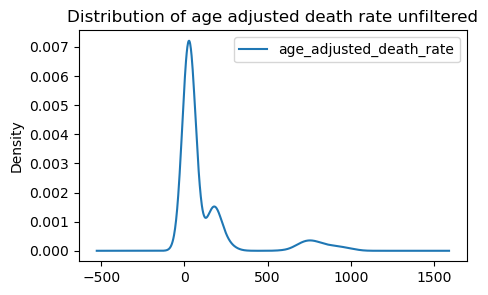

In [21]:
# Distribution of age_adjusted_death_rate
df_explore[['age_adjusted_death_rate']].plot(
    kind='kde',
    figsize=(5, 3),
    title='Distribution of age adjusted death rate unfiltered')

plt.legend(prop={'size': 10})

The statistic and distribution for the age adjusted death rate show:
- 75 % of the values are at or below 153.2 while the maximum goes up to 1061.2. This is a heavily right skewed distribution with alot of outliers since the IQR is at 134.
- The distribution visualizes this effect but does not explain it yet. It also shows that it is bimodal.
- The standard deviation shows that the values differ alot from the mean which can also be explained with the skew.

We need to take a more detailed look to correctly intrepret this distribution:

In [22]:
alt.Chart(df_explore).mark_bar().encode(
    alt.X("age_adjusted_death_rate:Q", title='Age-adjusted death rate',  bin=True),
    alt.Y(
        'count()',
        # scale=alt.Scale(type='log10')  # Here the scale is applied
        ),
    color = alt.Color('cause_name', scale=alt.Scale(scheme='set3'))
).properties(
    title = 'Distribution of age adjusted death rate by death cause' ,
  
)

alt.Chart(...)

Here we can see that the reason for the distribution clearly because the cause_name feature has individual causes as well as a summary for all causes stored within the same column. We will make another dataframe filtered by 'All causes' to serve as a summary dataset:

In [23]:
df_explore_causes_summarized = df_explore[df_explore.cause_name == 'All causes'].copy()

Let's look at the statistics and distribution of the age adjusted death rate again

In [24]:
df_explore_causes_summarized[['age_adjusted_death_rate']].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
age_adjusted_death_rate,675.0,800.13,98.12,572.0,724.4,784.5,869.5,1061.2


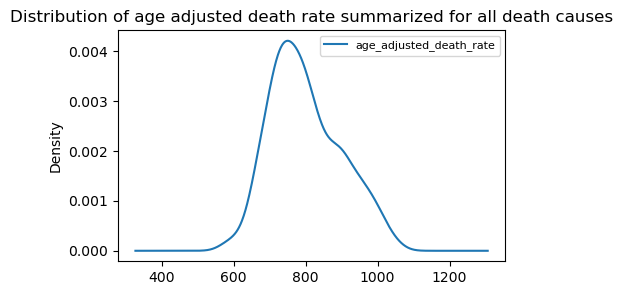

In [25]:
# Distribution of age_adjusted_death_rate
df_explore_causes_summarized[['age_adjusted_death_rate']].plot(
    kind='kde',
    figsize=(5, 3),
    title='Distribution of age adjusted death rate summarized for all death causes'
      )

plt.legend(prop={'size': 8})

We can see that the distribution has changed:
- The distribution is unimodal and still right skewed but alot closer to a normal distribution.
- We do not observe the wide range of values as before, there are no more outliers present.
- The mean is still higher than the median, which can be explained by the amount of high values around 900-1000.

Next we visualize the distribution for the median household income:

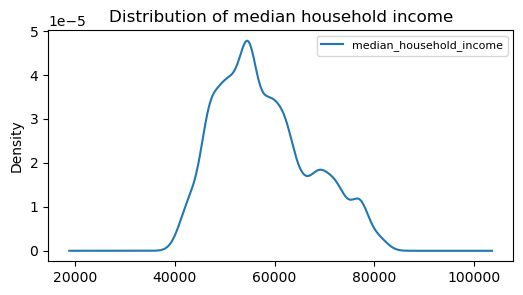

In [26]:
# Distribution of median_household_income
df_explore[['median_household_income']].plot(
    kind='kde',
    figsize=(6, 3),
    title='Distribution of median household income')

plt.legend(prop={'size': 8})

The [summary statistics](#stats) for the median household income in combination with the distribution show:

* The distribution is unimodal and right skewed extending from 40k \$ to over 80k $.
* The median is found at 56350 $ and with an IQR at 13000 there are no outliers present in the income data.
* The median (55800 $) is not in the middle between minimum and maximum (which would be around the mark where the third quartile is). This means the distribution is right skewed.

The imputed data is very close to the original data present in the income dataset. A [comparison for the distribution before and after the imputation](#imputation) can be found in the appendix.

To visualize the relation between age-adjusted death rate and median household income, we analyze scatterplots:

<a id='scatterplot_income'></a>

In [27]:
alt.Chart(df_explore_causes_summarized).mark_circle(size=60).encode(
    alt.X('median_household_income', title='Median household income ($)', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , title='Age-adjusted death rate', scale = alt.Scale(zero = False)),
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
).interactive()

alt.Chart(...)

There seems to be a moderate to strong negative correlation between the two variables.
We suspect the correlation to not be linear which we will investigate later.

[Additional data exploration](#additional_exploration) can be found in the appendix.

### Relationships

<a id='relationships'></a>

We will first look at the correlation of all features and then inspect the correlation for our summarized dataframe

In [28]:
#identify all categorical variables
list_cat = df_explore.select_dtypes(['category']).columns
#convert all categorical variables to numeric
df_explore[list_cat] = df_explore[list_cat].apply(lambda x: pd.factorize(x)[0])

In [29]:
# take a look at all correlations
corr = df_explore.corr()
corr.style.background_gradient(cmap='Blues')

,year,113_cause_name,cause_name,state,deaths,median_household_income,age_adjusted_death_rate
year,1.000000,0.005480,0.005480,0.002946,0.013353,-0.077663,-0.027888
113_cause_name,0.005480,1.000000,1.000000,0.007820,0.097992,-0.015742,0.402470
cause_name,0.005480,1.000000,1.000000,0.007820,0.097992,-0.015742,0.402470
state,0.002946,0.007820,0.007820,1.000000,0.004487,-0.023781,0.005450
deaths,0.013353,0.097992,0.097992,0.004487,1.000000,0.005334,0.224213
median_household_income,-0.077663,-0.015742,-0.015742,-0.023781,0.005334,1.000000,-0.031676
age_adjusted_death_rate,-0.027888,0.402470,0.402470,0.005450,0.224213,-0.031676,1.000000


We can see that both features 113_cause_name and cause_name provide the same information. Like we predicted we only need to keep one column for the model. Therefore we will drop the column '113_cause_name'.

We can ignore the obvious correlations between the age_adjusted_death_rate and cause_name, or deaths as well as deaths and cause_name, since those do not provide extra information.

For the summarized dataframe, the correlation matrix looks like this:

In [30]:
# inspect correlation for summarized cause name again
corr = df_explore_causes_summarized.corr()
corr.style.background_gradient(cmap='Blues')

,year,deaths,median_household_income,age_adjusted_death_rate
year,1.000000,0.033989,-0.078670,-0.446958
deaths,0.033989,1.000000,0.005858,-0.045224
median_household_income,-0.078670,0.005858,1.000000,-0.512797
age_adjusted_death_rate,-0.446958,-0.045224,-0.512797,1.000000


The correlation matrix shows, that there is a moderate to strong negative correlation for year and median_household_income. That means, that our hyphothesis is supported by the data. The data shows in addition, that the more years pass, the less people die (looking at data from 1999-2017) which could be explained by the improvements in the medical sector as well as the standard of living. To verifiy this assumption we would need further analysis and possibly more data, but this is not within the scope of out project.

No other significant correlation is visible.

## Methodology

> REMOVE THE FOLLOWING TEXT

This section includes a brief description of your modeling process.

Explain the reasoning for the type of model you're fitting, predictor variables considered for the model.

Additionally, show how you arrived at the final model by describing the model selection process, variable transformations (if needed), assessment of conditions and diagnostics, and any other relevant considerations that were part of the model fitting process.

# TO DO 
- Model Evaluation in Appendix schieben
- Verlinkungen herstellen
- Model Ergebnisse vergleichen 
    - Tabelle für coefficients für beide lineare modelle erstellen zum vergleichen
    - tabelle für error values erstellen für alle modelle und vergleichen
- extra Model erstellen das quadratische regression abbildet 
- Begründung durch residuenplot 

## Model

Since the predictor and the response variable are numeric and we try to find a pattern between them, we have a regression problem. We will start with simple linear regression even though we do not assume a linear relationship. 
In addition we use lasso regression and compare both models to see which performs better. 

We will only use the variable 'all causes' and filter the death rates by it, because we focus on the total deathrate in relation to the median household income.

Before we start we encode the categorical features as numeric features for the models and perform the data splitting again since we made changes. We will also drop the year column since we are not evaluating a time series and only use the extra data provided and the death column since it is already factor into the death rate.

In [31]:
# drop 113_cause_name column
df_joined.drop(['113_cause_name', 'year'], axis = 1, inplace = True)

# Filter only for cause_name = 'all_causes'
df_joined_summarized = df_joined[df_joined.cause_name == 'All causes'].copy()

# Drop cause name column since it only contains the same entry and death column since it is already 
df_joined_summarized.drop(['cause_name', 'deaths'], axis = 1, inplace = True)

# Reset index to fit new row number
df_joined_summarized.reset_index(drop = True, inplace = True)

# identify relevant numerical variables
list_num = df_joined_summarized.select_dtypes(include=[np.number]).columns.tolist()
list_num.remove(y_label)

#identify all categorical variables
list_cat = df_joined_summarized.select_dtypes(['category']).columns

#convert all categorical variables to numeric
df_joined_summarized[list_cat] = df_joined_summarized[list_cat].apply(lambda x: pd.factorize(x)[0])

# Perform data splitting
y_label = 'age_adjusted_death_rate'
features = df_joined_summarized.drop(columns=[y_label]).columns.tolist()
X = df_joined_summarized[features]
y = df_joined_summarized[y_label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# data training set
df_train = pd.DataFrame(X_train.copy())
df_train = df_train.join(pd.DataFrame(y_train))

### Linear Regression

#### Select model

In [32]:
# select the linear regression model
reg_lin = LinearRegression()

#### Training and validation

In [33]:
# cross-validation with 5 folds only on median_household_income since we use linear regression
scores_lin = cross_val_score(reg_lin, X_train[['median_household_income']], y_train, cv=5, scoring='neg_mean_squared_error') *-1

#### Fit model

In [34]:
# Fit the model to the median_household_income feature in the training data
reg_lin.fit(X_train[['median_household_income']], y_train)

LinearRegression()

#### Evaluation on test set

In [35]:
# obtain predictions
y_pred_lin = reg_lin.predict(X_test[['median_household_income']])

Save metrics for comparison

In [ ]:
# R squared
r2_lin = r2_score(y_test, y_pred_lin).round(3)
# MSE
MSE_lin = mean_squared_error(y_test, y_pred_lin).round(3)
# RMSE
RMSE_lin = mean_squared_error(y_test, y_pred_lin, squared=False).round(3)
# MAE
MAE_lin = mean_absolute_error(y_test, y_pred_lin).round(3)

#### Plot

In [135]:
# Make new dataframes for the altair charts
df_scatter = X_test.join(y_test)
# Make a series, set the index to the y_test series, make dataframe to join with X_test
series_y_pred_lin = pd.Series(y_pred_lin)
series_y_pred_lin.index = y_test.index
df_y_pred_lin = pd.DataFrame(series_y_pred_lin)
df_y_pred_lin.rename(columns = {0:'age_adjusted_death_rate'}, inplace = True)
df_line_lin = X_test.join(df_y_pred_lin)

# Make plots
scatter = alt.Chart(df_scatter).mark_circle(size=60).encode(
    alt.X('median_household_income', title='Median household income ($)', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , title='Age-adjusted death rate', scale = alt.Scale(zero = False)),
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
).interactive()

line_lin = alt.Chart(df_line_lin).mark_line(color= 'red').encode(
    alt.X('median_household_income', title='Median household income ($)', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , title='Age-adjusted death rate', scale = alt.Scale(zero = False)),
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
).interactive()

# Put plots together
plot_lin = scatter + line_lin
plot_lin

alt.LayerChart(...)

Further [analysis of the linear regression model](#linear_regression) outputs can be found in the appendix.

### Lasso Regression

First we need to standardize our numerical features, in order to use lasso regression:

In [39]:
# Make copies of the X matrices
X_train_las = X_train.copy()
X_test_las = X_test.copy()

# standardize the dataframes in order for lasso regression to work
scaler = StandardScaler().fit(X_train_las[list_num]) 

X_train_las[list_num] = scaler.transform(X_train_las[list_num])
X_test_las[list_num] = scaler.transform(X_test_las[list_num])

#### Select model

Next we let the algorithm chose which alpha (~number of features used in the model) provide the best results

In [40]:
# Lasso with 5 fold cross-validation
reg_las = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
reg_las.fit(X_train_las, y_train)

# Set best alpha
reg_las = Lasso(alpha=reg_las.alpha_)

# show best alpha
reg_las

Lasso(alpha=0.7649445649117792)

#### Training and validation

In [41]:
# cross-validation with 5 folds
scores_las = cross_val_score(reg_las, X_train_las, y_train, cv=5, scoring='neg_mean_squared_error') *-1

#### Fit model

In [42]:
# Fit the model to the complete training data
reg_las.fit(X_train_las, y_train)

Lasso(alpha=0.7649445649117792)

#### Evaluation on test set

In [43]:
# obtain predictions
y_pred_las = reg_las.predict(X_test_las)

Save metrics

In [44]:
# R squared
r2_las = r2_score(y_test, y_pred_las).round(3)
# MSE
MSE_las = mean_squared_error(y_test, y_pred_las).round(3)
# RMSE
RMSE_las = mean_squared_error(y_test, y_pred_las, squared=False).round(3)
# MAE
MAE_las = mean_absolute_error(y_test, y_pred_las).round(3)

Plot

In [136]:
# Make new dataframes for the altair charts
# Make a series, set the index to the y_test series, make dataframe to join with X_test
series_y_pred_las = pd.Series(y_pred_las)
series_y_pred_las.index = y_test.index
df_y_pred_las = pd.DataFrame(series_y_pred_las)
df_y_pred_las.rename(columns = {0:'age_adjusted_death_rate'}, inplace = True)
df_line_las = X_test.join(df_y_pred_las)

# Make plots
line_las = alt.Chart(df_line_las).mark_line(color= 'red').encode(
    alt.X('median_household_income', title='Median household income ($)', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , title='Age-adjusted death rate', scale = alt.Scale(zero = False)),
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
).interactive()

# Put plots together
plot_las = scatter + line_las
plot_las

alt.LayerChart(...)

Further [analysis of the lasso regression model](#lasso_regression) outputs can be found in the appendix.

### Polynomial Regression

#### Select model

In [143]:
alphas=np.logspace(-6, 6, 13)

reg_poly = RidgeCV(alphas=alphas)
reg_poly.fit(X_train,y_train)

reg_poly.alpha_

1000000.0

#### Fit model

In [144]:
# use polynomial features with degree 3
reg_poly = make_pipeline(
            PolynomialFeatures(degree=3), 
            RidgeCV(alphas=alphas)
            )

reg_poly.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('ridgecv',
                 RidgeCV(alphas=array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])))])

#### Evaluation on test set

In [145]:
# obtain predictions
y_pred_poly = reg_poly.predict(X_test)

#### Save metrics

In [ ]:
# R squared
r2_poly = r2_score(y_test, y_pred_poly).round(3)
# MSE
MSE_poly = mean_squared_error(y_test, y_pred_poly).round(3)
# RMSE
RMSE_poly = mean_squared_error(y_test, y_pred_poly, squared=False).round(3)
# MAE
MAE_poly = mean_absolute_error(y_test, y_pred_poly).round(3)

#### Plot

In [148]:
# Make new dataframes for the altair charts
# Make a series, set the index to the y_test series, make dataframe to join with X_test
series_y_pred_poly = pd.Series(y_pred_poly)
series_y_pred_poly.index = y_test.index
df_y_pred_poly = pd.DataFrame(series_y_pred_poly)
df_y_pred_poly.rename(columns = {0:'age_adjusted_death_rate'}, inplace = True)
df_line_poly = X_test.join(df_y_pred_poly)

# Make plots
line_poly = alt.Chart(df_line_poly).mark_line(color= 'red').encode(
    alt.X('median_household_income', title='Median household income ($)', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , title='Age-adjusted death rate', scale = alt.Scale(zero = False)),
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
).interactive()

# Put plots together
plot_poly = scatter + line_poly
plot_poly

alt.LayerChart(...)

#### Training and validation

#### Fit model

#### Evaluation on test set

In [142]:
metrics = {
    "Model":[
        "Linear Regression",
        "Lasso Regression",
        "Polynomial Regression",
    ],
     "R2":[
        r2_lin,
        r2_las,
        r2_poly
    ],
    "MSE":[
        MSE_lin,
        MSE_las,
        MSE_poly
    ],
    "RMSE":[
        RMSE_lin,
        RMSE_las,
        RMSE_poly
    ],
    "MAE":[
        MAE_lin,
        MAE_las,
        MAE_poly
    ]
}

metric_comparison = pd.DataFrame(metrics)
metric_comparison

,Model,R2,MSE,RMSE,MAE
0,Linear Regression,2.220000e-01,7.051781e+03,8.397500e+01,6.864900e+01
1,Lasso Regression,2.220000e-01,7.052469e+03,8.397900e+01,6.861600e+01
2,Polynomial Regression,-9.725867e+18,8.814397e+22,2.968905e+11,2.359423e+11


We can see that the model XXX performs the best given our data.

The next section gives a more indepth analysis to the model results.

### Save model 

In [ ]:
ts = time.time()
timestamp = datetime.datetime.fromtimestamp(ts).strftime('_%Y-%m-%d-%H_%M_%S')

joblib.dump(reg_lin, "../models/reg_lin_model.pkl" + timestamp )
joblib.dump(reg_las, "../models/reg_las_model.pkl" + timestamp )


## Results

> REMOVE THE FOLLOWING TEXT

This is where you will output the final model with any relevant model fit statistics.

Describe the key results from the model.
The goal is not to interpret every single variable in the model but rather to show that you are proficient in using the model output to address the research questions, using the interpretations to support your conclusions.

Focus on the variables that help you answer the research question and that provide relevant context for the reader.


# INTERPRETATION NOTWENDIG

## Discussion + Conclusion


> REMOVE THE FOLLOWING TEXT

In this section you'll include a summary of what you have learned about your research question along with statistical arguments supporting your conclusions.
In addition, discuss the limitations of your analysis and provide suggestions on ways the analysis could be improved.
Any potential issues pertaining to the reliability and validity of your data and appropriateness of the statistical analysis should also be discussed here.
Lastly, this section will include ideas for future work.

We have seen the following:

The correlation matrix in the [relationships section](#relationships) as well as the scatterplot in the [date exploration](#scatterplot_income) showed, that our hypothesis from the beginning is supported by the data. We stated that:
- **The household income and the death rate will have a negative correlation.**

There is a moderate to strong negative correlation for year and the median household income. The data shows in addition, that the more years pass, the less people die (looking at data from 1999-2017). We assumed that this could be explained by the improvements in the medical sector as well as the standard of living. We did not verify this assumption.

The linear regression model was not the best one because of the low R², high error values for MSE/ MAE/ RMSE.
It would be better to try out other models to get a better fit (ideas could be found in the appendix).

With the models we used, our research question could already be answered with a yes:

**Does the household income have an impact on the deathrates in the U.S. and if yes, how big is it?**

The impact is quantified by the metric R² and we have seen that the model XXXX performed the best.

### Outlook

We have seen a significant correlation between the age-adjusted death rate and the years. This could be further analyzed and additional time series models could be built.
It could be also interesting to carry out model fits, at the level of individual years and compare the metrics with each other, in order to be able to make statements over the years.

Another option is to build model ensembles to improve overall performance of the regression models.

For further analysis more data could be gathered to fill the gaps that we imputed in order to gain more realistic data.

In the appendix we made a [scatterplot](#additional_exploration) for every death cause related to the median household income that in certain states, certain death causes are more prominent than others. So the correlation between death rate and median household income could be interesting regarding the specific death cause. Perhaps, for certain causes of death, the rate increases with increasing income.



## Appendix
Not structured yet - additional information that may be used

### Additional Information regarding the research question

<a id='research_question'></a>

Our research question is backed by the following studies:
-  KINGE, Jonas Minet, et al. Association of household income with life expectancy and cause-specific mortality in Norway, 2005-2015. Jama, 2019, 321. Jg., Nr. 19, S. 1916-1925. (https://jamanetwork.com/journals/jama/article-abstract/2733322)
-  KAPLAN, George A., et al. Inequality in income and mortality in the United States: analysis of mortality and potential pathways. Bmj, 1996, 312. Jg., Nr. 7037, S. 999-1003. (https://www.bmj.com/content/312/7037/999.full)
-  O’CONNOR, Gerald T., et al. Median household income and mortality rate in cystic fibrosis. Pediatrics, 2003, 111. Jg., Nr. 4, S. e333-e339. (https://publications.aap.org/pediatrics/article-abstract/111/4/e333/63113/Median-Household-Income-and-Mortality-Rate-in)

Although the first study was done in Norway and the second study investigates mortality instead of death rate, we suspect to gather similar observations.

Added information on mortality rate:

*Mortality is a fact that refers to susceptibility to death. While there is a crude death rate that refers to number of deaths in a population in a year, mortality rate is the number of deaths per thousand people over a period of time that is normally a year.* (see: https://www.differencebetween.com/difference-between-death-rate-and-vs-mortality-rate/).

<a id='imputation'></a>

### Imputation Analysis

In [ ]:
df_imputation = pd.read_csv(processed_data + 'Joined_Dataset.csv')

In [ ]:
mno.matrix(df_imputation, figsize = (3, 2))

After joining, the median_household_income is now an additional column for the death data set.

We only have the median household income for the year 1990, 2000, 2005, 2010 and 2013-2017.
In the death dataset, we find the years starting from 1999 until 2017.
That is the reason why we only have 4576 non-null values for the median household income. 
This means that roughly 58 % of the column has empty values which we need to either fill (by imputing) or remove.

Since removing would lead to our dataset to be cut by over half, that is not a viable option.

First lets take a look at the summary statistics for the median household income and its distribution.

### Summary Statistics

In [ ]:
# Dataframe with only median household income as column
df_household_income = df_imputation[['median_household_income']]

# Summary statistics
df_household_income.describe().round(2).T

In [ ]:
# Interquartile range
q1 = df_household_income.quantile(q = 0.25)
q3 = df_household_income.quantile(q = 0.75)
iqr = q3-q1
iqr

Distribution

In [ ]:
# Distribution of median household income
df_household_income.plot(kind='kde', figsize=(8, 5), title='Distribution of median household income before imputation')

Plot

In [ ]:
df_imputation.info()

In [ ]:
# Scatterplot income over years before imputation
scatter_income_before = alt.Chart(df_imputation).mark_circle(size=60).encode(
    x=alt.X('year', 
            title='Year',
            scale=alt.Scale(domain = (1999,2018))
            ),
    y=alt.Y('median_household_income', 
            title='Median Household Income ($)',
            scale=alt.Scale(zero=False)
            ),
    tooltip=['year', 'median_household_income']
).interactive()

scatter_income_before

In [ ]:
# Boxplot over all income values before imputation
box_income_before = alt.Chart(df_household_income).mark_boxplot(size = 50).encode(
    x=alt.X('median_household_income', scale = alt.Scale(zero = False)),
    y=alt.Y()
).properties(
    width = 450,
    height = 80)

box_income_before

The distribution is unimodal and right skewed extending from 40k \$ to over 80k $.

The median is found at 56350 $ and with an IQR at 12950  there are no outliers present in the income data.

Also the values for the years 1999, 2001-2004, 2006-2009, 2011 & 2012 are missing.

### Imputed dataset

Let us take a look what the imputation has done for the missing values and how we can use the result:

Summary statistics

In [ ]:
# Compare the original and imputed median income column
df_income = df_imputation[['median_household_income']].copy()
df_income['income_KNN_Scaled'] = imputed_scaled['median_household_income']

# Obtain summary statistics
df_income.describe().T[['mean', 'std', 'min', '50%', 'max']]

In [ ]:
# Interquartile range
q1 = df_income.quantile(q = 0.25)
q3 = df_income.quantile(q = 0.75)
iqr = q3-q1
iqr

Distribution

In [ ]:
# Distribution of median household income
df_income.plot(kind='kde', figsize=(8, 5), title='Distribution of median household income after imputation')

Plot

In [ ]:
# Scatterplot income over years after imputation
scatter_income_after = alt.Chart(imputed_scaled).mark_circle(size=60).encode(
    x=alt.X('year', 
            title='Year',
            scale=alt.Scale(domain = (1999,2018))
            ),
    y=alt.Y('median_household_income', 
            title='Median Household Income ($)',
            scale=alt.Scale(zero=False)
            ),
    tooltip=['year', 'median_household_income']
).interactive()

# Vertical concatenation of scatterplots before and after imputation
alt.vconcat(scatter_income_before, scatter_income_after)


In [ ]:
# Boxplot over all income values after imputation
box_income_after = alt.Chart(imputed_scaled).mark_boxplot(size = 50).encode(
    x=alt.X('median_household_income', scale = alt.Scale(zero = False)),
    y=alt.Y()
).properties(
    width = 450,
    height = 80)

# Vertical concatenation of boxplots before and after imputation
alt.vconcat(box_income_before, box_income_after)

From the summary statistics we can see that the imputed values represent the original values quite good, the values are close to the existing ones. The IQR is slightly greater but there are still no outliers after the imputation. This can be explained with the method we used, since the KNN algorithm imputes the values by calculating distances to existing neighbour data points for every instance we want to replace. 

We found that by setting the number of neighbours (n_neighbours) to 1, the imputed data represents the original data the best without making assumptions. Since we are no domain experts, we want to change the data as little as possible.

The scatterplot shows that the missing values for median household income have been copied from years with existing values. For example the years 1999 - 2002 all share the values from 2000, 2003 - 2007 the values from 2005 and 2008 - 2011 the values from 2010. 2012 has been cipied from 2013.
This has the advantage, that it maintains the spread in the data. The disadvantage is, that we make the implicit assumption that the median household income by state stayed the same for the years close to 2000, 2005 and 2010.

This is visible by comparing the boxplots before and after imputation which are very similar. 

In reality the median income almost certainly did not stay the same, but for our case this gives a decent estimation for training our model.

This will leave us with 6 columns in total, which we can use for our data analysis (we will later disregard the 113 Cause name column since we will see, that the same information is provided by the cause name column):

### Additional data exploration

The scatterplots for the relation between median household income and age-adjusted death rate for every single category looks like this: 
<a id='additional_exploration'></a>



In [ ]:
Chart_CLRD=alt.Chart(df_imputation).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal='CLRD',)

).interactive()

Chart_Alzheimer=alt.Chart(df_imputation).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Alzheimer's disease")

).interactive()

Chart_Influenza=alt.Chart(df_imputation).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Influenza and pneumonia")

).interactive()

Chart_Suicide=alt.Chart(df_imputation).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Suicide")

).interactive()

Chart_Kidney=alt.Chart(df_imputation).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Kidney disease")

).interactive()

Chart_Unintentional=alt.Chart(df_imputation).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Unintentional injuries")

).interactive()

Chart_Diabetes=alt.Chart(df_imputation).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Diabetes")

).interactive()

Chart_Stroke=alt.Chart(df_imputation).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Stroke")

).interactive()

Chart_Cancer=alt.Chart(df_imputation).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Cancer")
    
    ).interactive()
    
Chart_Heart=alt.Chart(df_imputation).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Heart disease")

).interactive()

Horizontal1=Chart_CLRD | Chart_Alzheimer | Chart_Diabetes 
Horizontal2=Chart_Kidney | Chart_Suicide | Chart_Influenza 
Horizontal3=Chart_Stroke | Chart_Cancer | Chart_Heart | Chart_Unintentional
alt.vconcat(Horizontal1, Horizontal2, Horizontal3)

These charts are showing all death causes in detail. We have one chart for each death cause. Also there is the same negative correlation as in the plot for all death causes.

It seems like, that the death cause is only slightly influencing this correlation. Cancer seems like the death cause with the strongest negative correlation.
This could be used for further analysis and model training considering a specific death cause.

In [ ]:
alt.Chart(df_imputation).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative')
).properties(
    width=150,
    height=150
).repeat(
    row=['median_household_income', 'deaths', 'age_adjusted_death_rate'],
    column=['median_household_income', 'deaths', 'age_adjusted_death_rate']
).interactive()

In [ ]:
alt.Chart(df_imputation).mark_circle().encode(
    alt.X('year', scale=alt.Scale(zero=False)),
    alt.Y('age_adjusted_death_rate', scale=alt.Scale(zero=False, padding=1)),
    color='state', 
)

This chart could be interesting, if we could extend it and visualize the death rate per state and year.

In [ ]:
alt.Chart(df_imputation).mark_circle().encode(
    alt.X('year', scale=alt.Scale(zero=False)),
    alt.Y('median_household_income', scale=alt.Scale(zero=False, padding=1)),
    color='state', 
)

Also for additional analysis:
How is the household income developing year by year in the different states? Are there high variances? Is there a relationship to the death rates?

In [ ]:

alt.Chart(df_imputation).mark_bar(opacity=0.7).encode(
    x='cause_name:O',
    y=alt.Y('age_adjusted_death_rate:Q', stack=None),
    color="state",
    tooltip=['state']
    ).transform_filter(
    {'not':alt.FieldEqualPredicate(field='cause_name', equal='All causes')}

)

This graph is showing us, that heart disease in Arizona and cancer in South Dakota, are with distance the top death causes regarding death rate. We remember, that cancer has a really strong negative correlation with the median income.

Further analysis: How is the median income distributed year by year in South Dakoka?

In [ ]:
alt.Chart(
    df_imputation,
).mark_bar().encode(
    x=alt.X('cause_name:N', sort='-y'),
    y=alt.Y('age_adjusted_death_rate:Q'),
    color=alt.Color('cause_name:Q')

).transform_window(
    rank='rank(cause_name)',
    sort=[alt.SortField('cause_name', order='descending')]
).transform_filter(
    (alt.datum.rank < 5)
)

https://altair-viz.github.io/gallery/top_k_items.html

Data has to be customized to get a good visualization here.

## Map does not work!! Reason unknown and to be find out.


In [ ]:
df_mean_by_state = df_imputation[['state','median_household_income']].groupby('state').mean()
df_mean_by_state['state'] = df_mean_by_state.index
df_mean_by_state.reset_index(drop = True, inplace = True)

In [ ]:
fig = px.choropleth(df_mean_by_state,
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='median_household_income',
                    color_continuous_scale="Viridis", 
                    
                    )

fig.update_layout(
      title_text = 'Distribution of median household income in the US',
      title_font_family="Times New Roman",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )
fig.show()

### Model ideas

The following models could be interesting, because the models we have choosen were not ideal:
* Polynomial Regression, in case the relationship between predictor and response variable is not linear
* Bayesian Regression
* Decision Tree Regression, mainly xgboost
* Gradient Descent Regression

In order to find the best performing model, they could be compared using a specific metric (e.g. R², Mean Squared Error or Mean Absolute Error)

### Additional model result analysis
<a id='additional_model_results'></a>


#### Linear Regression
<a id='linear_regression'></a>


Cross Validation

In [ ]:
# store cross-validation scores
df_scores_lin = pd.DataFrame({"lr": scores_lin})

# reset index to match the number of folds
df_scores_lin.index += 1

# visualize MSE for each Fold
alt.Chart(df_scores_lin.reset_index()).mark_line(
     point=alt.OverlayMarkDef()
).encode(
    x=alt.X("index", bin=False, title="Fold", axis=alt.Axis(tickCount=5)),
    y=alt.Y("lr", aggregate="mean", title="Mean squared error (MSE)")
)

In [ ]:
df_scores_lin.describe().T

Coefficients

In [ ]:
# intercept
intercept = pd.DataFrame({
    "Name": ["Intercept"],
    "Coefficient":[reg_lin.intercept_]}
    )

# make a slope table
slope = pd.DataFrame({
    "Name": ["median_household_income"],
    "Coefficient": reg_lin.coef_}
)

# combine estimates of intercept and slopes
table = pd.concat([intercept, slope], ignore_index=True, sort=False)

round(table, 3)

Plot

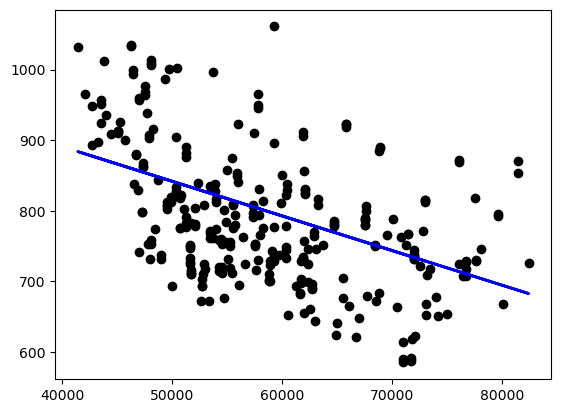

In [37]:
# Plot outputs for linear regression 
plt.scatter(X_test[['median_household_income']], y_test, color="black")
plt.plot(X_test[['median_household_income']], y_pred_lin, color="blue", linewidth=2)

#plt.xticks(())
#plt.yticks(())

plt.show()

#### Lasso Regression

<a id='lasso_regression'></a>


Cross Validation

In [ ]:
# store cross-validation scores
df_scores_las = pd.DataFrame({"lr": scores_las})

# reset index to match the number of folds
df_scores_las.index += 1

# visualize MSE for each Fold
alt.Chart(df_scores_las.reset_index()).mark_line(
     point=alt.OverlayMarkDef()
).encode(
    x=alt.X("index", bin=False, title="Fold", axis=alt.Axis(tickCount=5)),
    y=alt.Y("lr", aggregate="mean", title="Mean squared error (MSE)")
)

In [ ]:
df_scores_las.describe().T

Coefficients

In [ ]:
# intercept
intercept = pd.DataFrame({
    "Name": ["Intercept"],
    "Coefficient":[reg_las.intercept_]}
    )

# make a slope table
slope = pd.DataFrame({
    "Name": features,
    "Coefficient": reg_las.coef_}
)

# combine estimates of intercept and slopes
table = pd.concat([intercept, slope], ignore_index=True, sort=False)

round(table, 3)

This shows that the lasso regression in our case uses the same features to train the model (only median household income).